<a href="https://colab.research.google.com/github/aykb/Group-project-hand-in-/blob/main/aymeric_challenge3_modelling_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge 3 – Modelling Smart-City Energy Consumption

In this final challenge, you will build a **machine learning model** to predict daily energy consumption for smart-city buildings, and then analyse whether the model behaves **fairly** across different building groups.

We will reuse the tidy dataset you created in **Challenge 1**:

- `energy_daily_features.csv` (one row per building and day)

Goals:

- Predict `daily_grid_import_kwh` using calendar features and simple lag features, for each building.
- Compare linear and non-linear models.
- **Evaluate fairness of prediction errors across building types and locations.**



In [ ]:
# 🔧 Setup
# In Google Colab you may want to run:
!pip install -q pandas numpy matplotlib scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

plt.rcParams['figure.figsize'] = (10, 4)



## 1. Load the daily energy dataset

1. Upload or mount the file `energy_daily_features.csv` generated in Challenge 1.  
2. Load it into a DataFrame `energy_daily`.  
3. Inspect the first rows and the columns.



In [ ]:
# TODO: load the CSV (adapt the path if needed)
energy_daily = pd.read_csv("sample_data/energy_daily_features.csv")

energy_daily = pd.DataFrame(energy_daily)  # TODO

# TODO: inspect the dataframe: head(), info(), describe()

energy_daily.head()
energy_daily.info()
energy_daily.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1603 entries, 0 to 1602
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1603 non-null   object 
 1   building_id            1603 non-null   object 
 2   building_type          1603 non-null   object 
 3   location               1603 non-null   object 
 4   daily_grid_import_kwh  1603 non-null   float64
 5   cluster                1603 non-null   int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 75.3+ KB


,daily_grid_import_kwh,cluster
count,1603.000000,1603.000000
mean,132802.660879,0.952589
std,96858.262083,0.771041
min,0.364000,0.000000
25%,35996.849000,0.000000
50%,157265.805000,1.000000
75%,245930.064000,2.000000
max,245930.064000,2.000000


## 2. Feature engineering

Create features capturing temporal patterns and short-term dynamics:

- Calendar:
  - `day_of_week` (0–6)
  - `month` (1–12)
  - `is_weekend` (0/1)
- Lag features (per building):
  - `lag1` = previous day's `daily_grid_import_kwh`
  - `lag7` = value 7 days before

Steps:

1. Convert `date` to a datetime.  
2. Sort by `building_id` and `date`.  
3. Use `groupby("building_id")` + `shift()` to create `lag1` and `lag7`.  
4. Drop rows where lag features are missing.



In [ ]:
energy_daily['date'] = pd.to_datetime(energy_daily['date'])
energy_daily['day_of_week'] = energy_daily['date'].dt.dayofweek
energy_daily['month'] = energy_daily['date'].dt.month
energy_daily['is_weekend'] = (energy_daily['date'].dt.dayofweek >= 5).astype(int)

energy_daily = energy_daily.sort_values(['building_id', 'date'])
energy_daily['lag1'] = energy_daily.groupby('building_id')['daily_grid_import_kwh'].shift(1)
energy_daily['lag7'] = energy_daily.groupby('building_id')['daily_grid_import_kwh'].shift(7)

# Drop rows with NaNs in lag features
energy_daily_model = energy_daily.dropna(subset=['lag1', 'lag7']).copy()

## 3. Train/test split

For simplicity, we will:

- Use all buildings together.
- Randomly split rows into **train** (80%) and **test** (20%).  
  (In production, you would usually use a *time-based* split.)

1. Define the target `y = daily_grid_import_kwh`.  
2. Define feature matrix `X` using:
   - calendar features (`day_of_week`, `month`, `is_weekend`)
   - lag features (`lag1`, `lag7`)
   - optionally `building_type` and `location` encoded as dummy variables.
3. Call `train_test_split`.



In [ ]:
from sklearn.model_selection import train_test_split

# TODO: build X, y

energy_model = pd.get_dummies(energy_daily_model, columns=['building_type', 'location'], drop_first=True)

y = energy_model['daily_grid_import_kwh']

dummy_cols = [col for col in energy_model.columns if 'building_type_' in col or 'location_' in col]
feature_cols = ['day_of_week', 'month', 'is_weekend', 'lag1', 'lag7'] + dummy_cols

X = energy_model[feature_cols]

# TODO: perform train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 4. Baseline model & evaluation (Linear Regression)

1. Train a **Linear Regression** model and report:
   - RMSE (root mean squared error)
   - R² score
2. Plot predicted vs actual values on the test set.



Linear Regression RMSE: 67.93
Linear Regression R^2: 1.0000


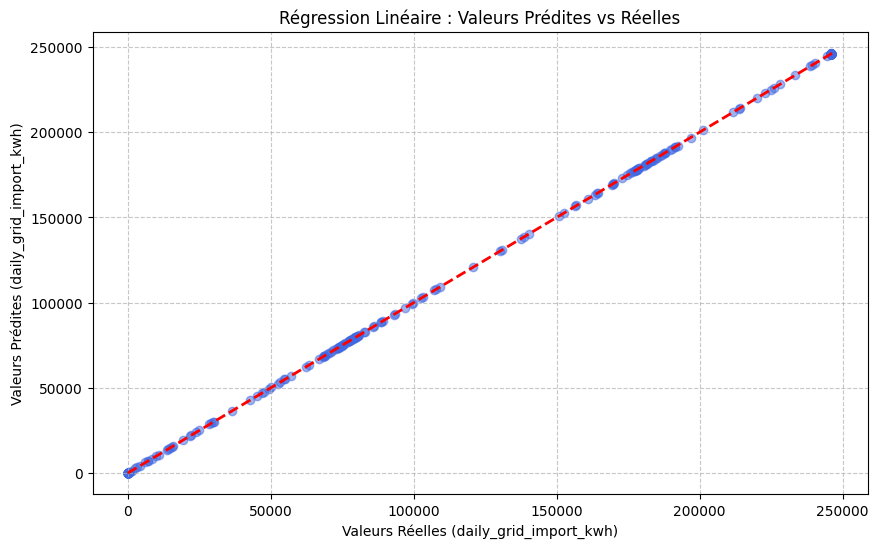

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# 1. TODO: fit a LinearRegression model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# 2. TODO: evaluate on test set
y_pred_lin = linreg.predict(X_test)

# Calcul du RMSE et R²
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
r2_lin = r2_score(y_test, y_pred_lin)

print(f"Linear Regression RMSE: {rmse_lin:.2f}")
print(f"Linear Regression R^2: {r2_lin:.4f}")

# 3. TODO: scatter plot predicted vs actual for Linear Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lin, alpha=0.5, color='royalblue')

# Ajout d'une ligne de référence (y = x)
max_val = max(y_test.max(), y_pred_lin.max())
min_val = min(y_test.min(), y_pred_lin.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', lw=2, linestyle='--')

plt.title('Régression Linéaire : Valeurs Prédites vs Réelles')
plt.xlabel('Valeurs Réelles (daily_grid_import_kwh)')
plt.ylabel('Valeurs Prédites (daily_grid_import_kwh)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 5. Non-linear model & feature importance (Random Forest)

1. Train a **RandomForestRegressor** on the same features.  
2. Compare RMSE and R² to the linear model.  
3. Display feature importances for interpretability.



Random Forest RMSE: 231.14
Random Forest R^2: 1.0000

Amélioration du R² par rapport au linéaire: -0.0%


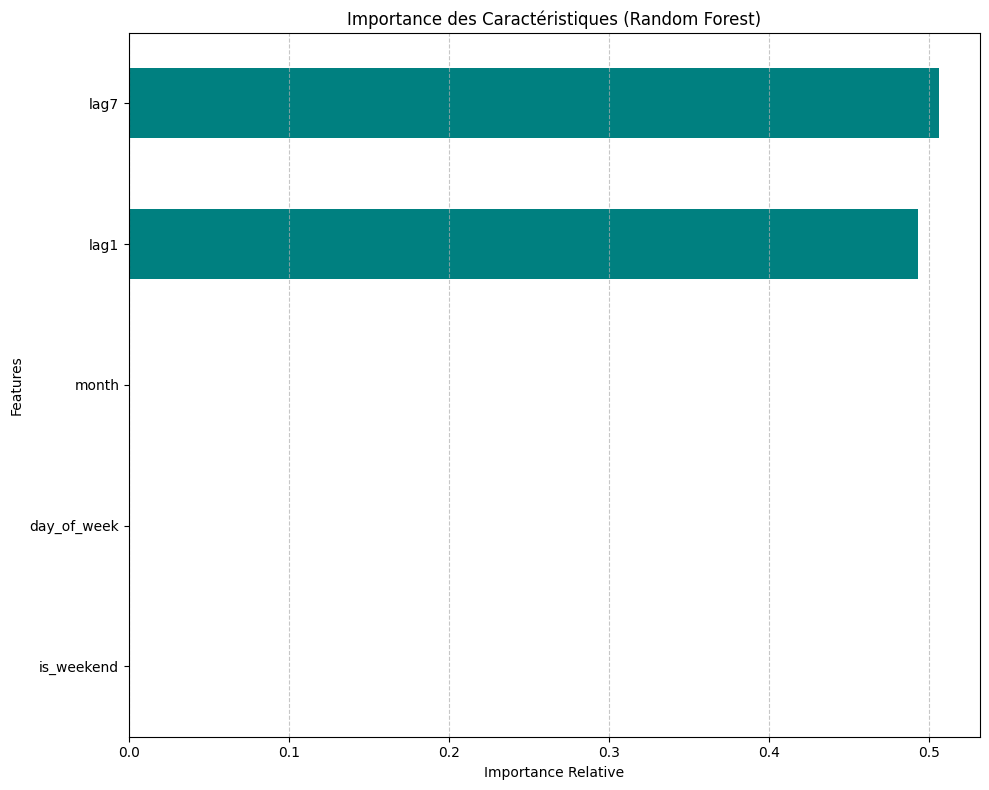

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. TODO: fit a RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# 2. TODO: evaluate on test set
y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"Random Forest R^2: {r2_rf:.4f}")

# --- Comparaison rapide ---
print(f"\nAmélioration du R² par rapport au linéaire: {((r2_rf - r2_lin) / r2_lin)*100:.1f}%")

# 3. TODO: show feature importances
importances = rf.feature_importances_
feature_names = X.columns
rf_importances = pd.Series(importances, index=feature_names).sort_values(ascending=True)

plt.figure(figsize=(10, 8))
rf_importances.plot(kind='barh', color='teal')
plt.title('Importance des Caractéristiques (Random Forest)')
plt.xlabel('Importance Relative')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 6. Fairness of prediction errors across building groups

In a smart-city context, it is not enough to have good *global* accuracy.  
We also want to avoid **systematically worse errors** for some building groups (e.g. schools vs residential, urban vs suburban).

We will analyse the **absolute error** of each model for different groups.

Steps:

1. Build a `test_results` DataFrame for the test set that contains:
   - `building_id`, `building_type`, `location`
   - `y_true` (actual `daily_grid_import_kwh`)
   - `y_pred_lin`, `y_pred_rf`
   - `abs_error_lin`, `abs_error_rf`
2. Compute group-level error metrics:
   - Mean absolute error (MAE) by `building_type`
   - MAE by `location`
3. Interpret whether any group has **systematically higher error**.



In [ ]:
# 1. TODO: reconstruct a DataFrame with metadata for the test rows.
# Hint: energy_daily_model still has building_id, building_type, location.
# Use X_test.index to align rows.

test_meta = energy_daily_model.loc[X_test.index, ['building_id', 'building_type', 'location']]
test_results = test_meta.copy()
test_results['y_true'] = y_test.values
test_results['y_pred_lin'] = y_pred_lin
test_results['y_pred_rf'] = y_pred_rf
test_results['abs_error_lin'] = (test_results['y_true'] - test_results['y_pred_lin']).abs()
test_results['abs_error_rf'] = (test_results['y_true'] - test_results['y_pred_rf']).abs()

# 2. TODO: compute group-wise mean absolute errors
mae_by_type = test_results.groupby('building_type')[['abs_error_lin', 'abs_error_rf']].mean()
mae_by_location = test_results.groupby('location')[['abs_error_lin', 'abs_error_rf']].mean()

# 3. TODO: display results
print("Mean Absolute Error by Building Type:")
display(mae_by_type)
print("\nMean Absolute Error by Location:")
display(mae_by_location)

Mean Absolute Error by Building Type:


,abs_error_lin,abs_error_rf
building_type,,
residential,39.685358,92.837295



Mean Absolute Error by Location:


,abs_error_lin,abs_error_rf
location,,
urban,39.685358,92.837295


## 7. Short discussion

In a short markdown cell, answer:

- Which model performs better on this dataset (overall)?  
- Which features are most important (according to Random Forest)?  
- Do some building groups (by type or location) have systematically higher prediction errors?  
- How could you use this analysis to design **fairer** energy management policies (e.g. if a group has high error, what would you change: more data, separate models, calibration, etc.)?



Le modele de régression linéaire semble être le plus performant, en regardant le MAE, on passe de 39.69 à 92.84 avec la random forest.
La random forest est donc en overfitting.
Les variables importantes sont lag7 et lag1. Et les variables contextuelles semblent pas jouer un role important.
Pour gérer l'énergie de facon plus juste, on peut allouer des capteurs, des modèles dédiés.

## 8. *Optional* – Design a simple regression fairness metric (link to Challenge 2)

In **Challenge 2**, you used IBM AIF360 to compute fairness metrics such as:

- *Statistical Parity Difference*  
- *Disparate Impact*

These metrics were defined for **classification** problems (binary labels).

Here, we have a **regression** problem (continuous target: daily energy).  
We approximated fairness by comparing **group-wise mean absolute errors (MAE)**.

### Your task (optional)

1. Propose a *simple fairness metric for regression* inspired by AIF360-style ratios or differences. For example:
   - A *fairness gap* defined as the difference between the **max** and **min** group-wise MAE across building types or locations.
   - Or a *fairness ratio* defined as the ratio between the **largest** and **smallest** group-wise MAE.
2. Implement your metric in code for both models:
   - One value for Linear Regression.
   - One value for Random Forest.
3. Interpret the results:
   - Which model is “fairer” according to your metric?
   - How does this connect back to the fairness notions you used in Challenge 2?



In [ ]:
# OPTIONAL TODO:
# Starting from mae_by_type or mae_by_location, define a simple fairness metric.
#
# Example sketch (feel free to change):
# max_mae_lin = mae_by_type['abs_error_lin'].max()
# min_mae_lin = mae_by_type['abs_error_lin'].min()
# fairness_gap_lin = max_mae_lin - min_mae_lin
#
# Repeat for Random Forest and/or by location, then print and interpret.

# Your code here ...

